In [1]:
import torch
from hyperpartisan_dataset import ArticleDataset
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import get_scheduler
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, random_split
import evaluate as evaluate
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import copy

In [2]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cuda'
train_size = 0.8
val_size = 0.1
batch_size = 30
train_mask = range(50)
num_labels = 2
model_name = 'distilbert-base-uncased'
lr = 1e-4
num_epochs = 10

In [3]:
dataset = ArticleDataset(article_file='./hyperpartisan/articles-training-byarticle-20181122.xml', 
                         label_file='./hyperpartisan/ground-truth-training-byarticle-20181122.xml')
total_length = len(dataset)
train_length = int(total_length * train_size)
val_length = int(total_length * val_size)
test_length = int(total_length - (train_length + val_length))
train_dataset, val_dataset, test_dataset= random_split(dataset, [train_length, val_length, test_length])

In [4]:
# small subset
# train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
#                                 sampler=SubsetRandomSampler(train_mask))
# validation_dataloader = DataLoader(val_dataset, batch_size=batch_size,
#                                 sampler=SubsetRandomSampler(train_mask))
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size,
#                                 sampler=SubsetRandomSampler(train_mask))

# all data
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [5]:
# for batch in train_dataloader:
#     print("Batch:")
#     print("ID: ", batch['id'])
#     print("Article: ", batch['body'])
#     print("hyperpartisan: ", batch['hyperpartisan'])
#     break

In [6]:
pretrained_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels = num_labels)
pretrained_model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'classifier

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [7]:
def train(mymodel, num_epochs, train_dataloader, validation_dataloader,device, lr):
    """ Train a PyTorch Module
    :param torch.nn.Module mymodel: the model to be trained
    :param int num_epochs: number of epochs to train for
    :param torch.utils.data.DataLoader train_dataloader: DataLoader containing training examples
    :param torch.utils.data.DataLoader validation_dataloader: DataLoader containing validation examples
    :param torch.device device: the device that we'll be training on
    :param float lr: learning rate
    :return None
    """
    
    # store for plotting
    train_acc_epoch = []
    train_acc_batch = []
    val_acc_epoch = []
    val_acc_batch = []
    
    max_ = 0
    Best_model = None
    
    
    # with open(f'results/{classifier_name}_val_acc_batch' + '.pickle', 'wb') as f:
    #     pickle.dump((val_acc_batch), f)
    #     f.close()


    # here, we use the AdamW optimizer. Use torch.optim.Adam.
    # instantiate it on the untrained model parameters with a learning rate of 5e-5
    # print(" >>>>>>>>  Initializing optimizer")
    optimizer = torch.optim.AdamW(mymodel.parameters(), lr=lr)

    # now, we set up the learning rate scheduler
    lr_scheduler = get_scheduler(
        "linear",
        optimizer=optimizer,
        num_warmup_steps=50,
        num_training_steps=len(train_dataloader) * num_epochs
    )

    loss = torch.nn.CrossEntropyLoss()

    for epoch in range(num_epochs):

        # put the model in training mode (important that this is done each epoch,
        # since we put the model into eval mode during validation)
        mymodel.train()

        # load metrics
        train_accuracy = evaluate.load('accuracy')
        

        print(f"Epoch {epoch + 1} training:")

        for i, batch in enumerate(tqdm(train_dataloader)):
            
            #load metrics
            #train_accuracy_batch = evaluate.load('accuracy')

            """
            You need to make some changes here to make this function work.
            Specifically, you need to: 
            Extract the input_ids, attention_mask, and labels from the batch; then send them to the device. 
            Then, pass the input_ids and attention_mask to the model to get the logits.
            Then, compute the loss using the logits and the labels.
            Then, call loss.backward() to compute the gradients.
            Then, call optimizer.step()  to update the model parameters.
            Then, call lr_scheduler.step() to update the learning rate.
            Then, call optimizer.zero_grad() to reset the gradients for the next iteration.
            Then, compute the accuracy using the logits and the labels.
            """

            # print(batch)
            input_ids = batch['id'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            output = mymodel(input_ids, attention_mask=attention_mask)
            predictions = output.logits

            model_loss = loss(predictions, labels)

            model_loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            predictions = torch.argmax(predictions, dim=1)

            # update metrics for train epoch 
            train_accuracy.add_batch(predictions=predictions, references=labels)
            
            # update metrics for train batch
            correct = (predictions == labels).sum().item()
            train_accuracy_batch = correct/len(predictions)
            train_acc_batch.append(train_accuracy_batch)
                  
                   
        #compute for train epoch
        acc = train_accuracy.compute()
        train_acc_epoch.append(acc["accuracy"])
        
        # print evaluation metrics
        print(f" ===> Epoch {epoch + 1}")
        print(f" - Average training metrics: accuracy={acc}")
        
        # normally, validation would be more useful when training for many epochs
        val_accuracy = evaluate_model(mymodel, validation_dataloader, device)
        val_acc_epoch.append(val_accuracy["accuracy"])
        
        print(f" - Average validation metrics: accuracy={val_accuracy}")
        
        
        
        if (val_acc_epoch[epoch] > max_):
            max_ = val_acc_epoch[epoch]
            saved_model_path = f'./saved_models/hyperpartisan/'#model_M2.1_hyperpartisan_DistilBERT_classifier'
            torch.save(mymodel, f"{saved_model_path}model_M2.1_hyperpartisan_DistillBert_Classifier.pt")
            Best_model = copy.deepcopy(mymodel)
            Best_model.save_pretrained(saved_model_path)
        
        
    # with open(f'results/{classifier_name}_train_acc_epoch' + '.pickle', 'wb') as f:
    #     pickle.dump((train_acc_epoch), f)
    #     f.close()
       

    # with open(f'results/{classifier_name}_train_acc_batch' + '.pickle', 'wb') as f:
    #     pickle.dump((train_acc_batch), f)
    #     f.close()
        
        
    # with open(f'results/{classifier_name}_val_acc_epoch' + '.pickle', 'wb') as f:
    #     pickle.dump((val_acc_epoch), f)  
    #     f.close()
        
        
    # with open(f'results/{classifier_name}_val_acc_batch' + '.pickle', 'wb') as f:
    #     pickle.dump((val_acc_batch), f)
    #     f.close()

    
    plt.plot(train_acc_epoch, '-o', label = 'training accuracy', color = 'blue')
    plt.plot(val_acc_epoch, '-o', label = 'validation accuracy', color = 'orange')    
    plt.title("Training and Validation Accuracies")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()
    
    return Best_model

def evaluate_model(model, dataloader, device, acc_only=True):
    """ Evaluate a PyTorch Model
    :param torch.nn.Module model: the model to be evaluated
    :param torch.utils.data.DataLoader test_dataloader: DataLoader containing testing examples
    :param torch.device device: the device that we'll be training on
    :param bool acc_only: return only accuracy if true, else also return ground truth and pred as tuple
    :return accuracy (also return ground truth and pred as tuple if acc_only=False)
    """
    # load metrics
    dev_accuracy = evaluate.load('accuracy')
    
    # turn model into evaluation mode
    model.eval()

    #Y_true and Y_pred store for epoch
    Y_true = []
    Y_pred = []
    val_acc_batch = []
    
    
    val_accuracy_batch = evaluate.load('accuracy')
    
    
    for batch in tqdm(dataloader):
        input_ids = batch['id'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        output = model(input_ids=input_ids, attention_mask=attention_mask)
        
       
        predictions = output.logits
        predictions = torch.argmax(predictions, dim=1)
        Y_true += batch['labels'].tolist()
        Y_pred += predictions.tolist()
        dev_accuracy.add_batch(predictions=predictions, references=batch['labels'])
        
        if acc_only == True:
            correct = (predictions.to(device) == batch['labels'].to(device)).sum().item()
            val_accuracy_batch = correct/len(predictions)
            val_acc_batch.append(val_accuracy_batch)
            
      

    # compute and return metrics
#     Y_true = np.squeeze(np.array(Y_true))
#     Y_pred = np.squeeze(np.array(Y_pred))
    
#     load_new_list(f'results/{classifier_name}_val_acc_batch',val_acc_batch)
    
    return dev_accuracy.compute() if acc_only else (dev_accuracy.compute(),Y_true,Y_pred)

Epoch 1 training:


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:06<00:00,  2.98it/s]


 ===> Epoch 1
 - Average training metrics: accuracy={'accuracy': 0.6007751937984496}


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 10.09it/s]


 - Average validation metrics: accuracy={'accuracy': 0.546875}
Epoch 2 training:


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:06<00:00,  2.87it/s]


 ===> Epoch 2
 - Average training metrics: accuracy={'accuracy': 0.6937984496124031}


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.99it/s]


 - Average validation metrics: accuracy={'accuracy': 0.765625}
Epoch 3 training:


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:05<00:00,  3.06it/s]


 ===> Epoch 3
 - Average training metrics: accuracy={'accuracy': 0.8255813953488372}


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 11.95it/s]


 - Average validation metrics: accuracy={'accuracy': 0.765625}
Epoch 4 training:


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:05<00:00,  3.33it/s]


 ===> Epoch 4
 - Average training metrics: accuracy={'accuracy': 0.8895348837209303}


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 11.20it/s]


 - Average validation metrics: accuracy={'accuracy': 0.84375}
Epoch 5 training:


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:05<00:00,  3.28it/s]


 ===> Epoch 5
 - Average training metrics: accuracy={'accuracy': 0.9573643410852714}


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 10.85it/s]


 - Average validation metrics: accuracy={'accuracy': 0.90625}
Epoch 6 training:


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:05<00:00,  3.26it/s]


 ===> Epoch 6
 - Average training metrics: accuracy={'accuracy': 0.9844961240310077}


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.89it/s]


 - Average validation metrics: accuracy={'accuracy': 0.890625}
Epoch 7 training:


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:05<00:00,  3.30it/s]


 ===> Epoch 7
 - Average training metrics: accuracy={'accuracy': 1.0}


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 11.10it/s]


 - Average validation metrics: accuracy={'accuracy': 0.875}
Epoch 8 training:


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:05<00:00,  3.27it/s]


 ===> Epoch 8
 - Average training metrics: accuracy={'accuracy': 1.0}


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 11.07it/s]


 - Average validation metrics: accuracy={'accuracy': 0.875}
Epoch 9 training:


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:05<00:00,  3.31it/s]


 ===> Epoch 9
 - Average training metrics: accuracy={'accuracy': 1.0}


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 11.12it/s]


 - Average validation metrics: accuracy={'accuracy': 0.875}
Epoch 10 training:


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:05<00:00,  3.33it/s]


 ===> Epoch 10
 - Average training metrics: accuracy={'accuracy': 1.0}


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 11.19it/s]


 - Average validation metrics: accuracy={'accuracy': 0.875}


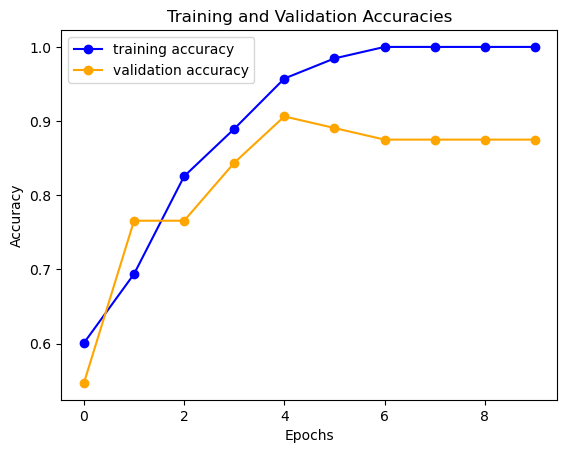

In [8]:
trained_model = train(pretrained_model, num_epochs, train_dataloader, validation_dataloader, device, lr)